In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import joblib

## Import the Data

In [2]:
data = pd.read_csv('transfusion.csv')
data.head(3)

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1


## Data Preprocessing

In [3]:
data.shape

(748, 5)

In [4]:
data.isnull().sum()

Recency (months)                              0
Frequency (times)                             0
Monetary (c.c. blood)                         0
Time (months)                                 0
whether he/she donated blood in March 2007    0
dtype: int64

In [5]:
data.duplicated().sum()

215

In [6]:
data=data.drop_duplicates()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            533 non-null    int64
 1   Frequency (times)                           533 non-null    int64
 2   Monetary (c.c. blood)                       533 non-null    int64
 3   Time (months)                               533 non-null    int64
 4   whether he/she donated blood in March 2007  533 non-null    int64
dtypes: int64(5)
memory usage: 25.0 KB


In [8]:
data.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
count,533.000000,533.000000,533.000000,533.000000,533.00000
mean,9.529081,6.990619,1747.654784,42.303940,0.27955
std,8.250860,6.265875,1566.468760,23.295291,0.44920
min,0.000000,1.000000,250.000000,2.000000,0.00000
25%,3.000000,3.000000,750.000000,26.000000,0.00000
50%,8.000000,5.000000,1250.000000,38.000000,0.00000
75%,14.000000,9.000000,2250.000000,58.000000,1.00000
max,74.000000,50.000000,12500.000000,98.000000,1.00000


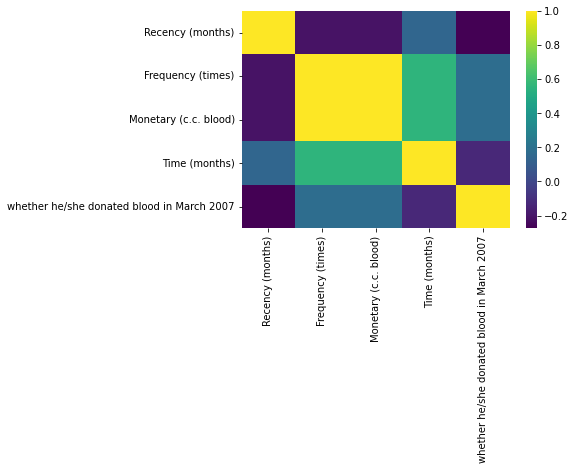

In [9]:
sns.heatmap(data.corr(),cmap='viridis');

In [10]:
data.columns = data.columns.str.replace(' ', '_')
data.head(3)

,Recency_(months),Frequency_(times),Monetary_(c.c._blood),Time_(months),whether_he/she_donated_blood_in_March_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1


## Splitting Data

In [11]:
X = data.drop('whether_he/she_donated_blood_in_March_2007', axis=1).copy()
X.head(3)

,Recency_(months),Frequency_(times),Monetary_(c.c._blood),Time_(months)
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35


In [12]:
y = data['whether_he/she_donated_blood_in_March_2007'].copy()
y.head(3)

0    1
1    1
2    1
Name: whether_he/she_donated_blood_in_March_2007, dtype: int64

In [13]:
y.unique()

array([1, 0], dtype=int64)

## Build a Preliminary XGBoost Model

let's see if our dataset is balanced or imbalanced by dividing the number of people who donated in March 2007, where $y=1$ by the total number of people.

In [14]:
sum(y)/len(y)

0.2795497185741088

so we see that only **28%** of the people in the dataset donated in March 2007. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who donated in March 2007 in both the **training** set and the **testing** set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

verifying that using **stratify** worked as expected

In [16]:
sum(y_train)/len(y_train)

0.2807017543859649

In [17]:
sum(y_test)/len(y_test)

0.27611940298507465

In [18]:
y_train.shape

(399,)

In [19]:
y_test.shape

(134,)

In [20]:
X_train = X_train.values
X_test = X_test.values

In [21]:
std_scaler= StandardScaler()  
X_train= std_scaler.fit_transform(X_train)  
X_test= std_scaler.transform(X_test)  
X_train

array([[-0.73654055, -0.50058206, -0.50058206, -0.06971724],
       [-0.73654055,  0.28762726,  0.28762726,  0.14625464],
       [-0.04178953, -0.65822393, -0.65822393,  0.40542088],
       ...,
       [-1.01444095,  1.23347845,  1.23347845,  0.92375338],
       [ 0.23611087, -0.50058206, -0.50058206,  0.7077815 ],
       [-1.01444095,  1.39112032,  1.39112032,  1.65805774]])

In [22]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            early_stopping_rounds = 10,
                            eval_metric = 'auc')
clf_xgb.fit(X_train,
            y_train,
            verbose=1,
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.67275
[1]	validation_0-auc:0.65534
[2]	validation_0-auc:0.65060
[3]	validation_0-auc:0.66091
[4]	validation_0-auc:0.65436
[5]	validation_0-auc:0.65060
[6]	validation_0-auc:0.64656
[7]	validation_0-auc:0.65589
[8]	validation_0-auc:0.65770
[9]	validation_0-auc:0.65046
[10]	validation_0-auc:0.64475


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

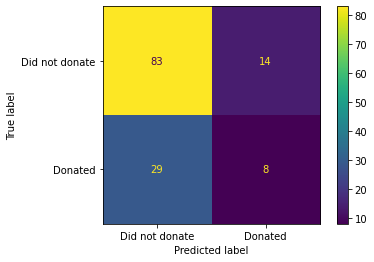

In [23]:
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_test, y_test, display_labels=["Did not donate", "Donated"])

In the confusion matrix, we see that of the **97** people that **did not donate, 83 (85.56%)** were correctly classified. And of the **37** people that **donated, 8 (21.62%)** were correctly classified (Recall/Sensitivity) . So the **XGBoost** model was not awesome. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in the confusion matrix with the top row showing **97** people that did not donate and the bottom row showing **37** people who did. Because in Emergency cases we want to reach people who donated, we would like to capture more of them.
XGBoost has a parameter **scale_pos_weight**, that helps with imbalanced data.

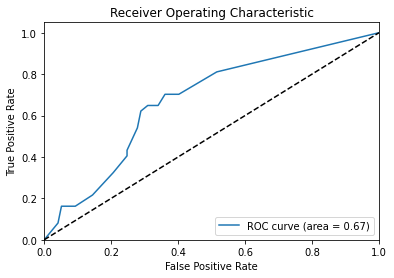

In [24]:
# Predict probabilities for test data
y_scores = clf_xgb.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Hyperparameters Tuning

In [25]:
#round 1
param_grid = {
    'gamma': [0, 0.25, 1.0],
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [2, 3, 4],
    'reg_lambda': [1.0, 10.0, 50.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(subsample=0.9,
                                  colsample_bytree=0.5,
                                  early_stopping_rounds=10,
                                  eval_metric = 'auc'),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose=0,
    n_jobs=-1,
    cv=3)

optimal_params.fit(X_train, 
                   y_train, 
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}


In [26]:
#round 2
param_grid = {
    'gamma': [0, 0.1, 0.25],
    'learning_rate': [0.1, 0.5, 0.8],
    'max_depth': [1, 2, 3],
    'reg_lambda': [1, 10, 100],
    'scale_pos_weight': [3]
}

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(subsample=0.9,
                                  colsample_bytree=0.5,
                                  early_stopping_rounds=10,
                                  eval_metric = 'auc'),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose=0,
    n_jobs=-1,
    cv=3)

optimal_params.fit(X_train, 
                   y_train, 
                   eval_set=[(X_test, y_test)],
                   verbose=False)
print(optimal_params.best_params_)

{'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 2, 'reg_lambda': 10, 'scale_pos_weight': 3}


## Building Model with tuned parameters

In [27]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            gamma=0.25,
                            learning_rate = 0.8,
                            max_depth = 2,
                            reg_lambda = 100,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=10,
                            eval_metric='auc',
                            random_state=42)

clf_xgb.fit(X_train,
            y_train,
            verbose=1,
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.67233
[1]	validation_0-auc:0.70465
[2]	validation_0-auc:0.69657
[3]	validation_0-auc:0.68794
[4]	validation_0-auc:0.72193
[5]	validation_0-auc:0.73558
[6]	validation_0-auc:0.73196
[7]	validation_0-auc:0.72889
[8]	validation_0-auc:0.72611
[9]	validation_0-auc:0.72917
[10]	validation_0-auc:0.73112
[11]	validation_0-auc:0.73126
[12]	validation_0-auc:0.73697
[13]	validation_0-auc:0.73084
[14]	validation_0-auc:0.73224
[15]	validation_0-auc:0.73335
[16]	validation_0-auc:0.73642
[17]	validation_0-auc:0.73461
[18]	validation_0-auc:0.73572
[19]	validation_0-auc:0.73628
[20]	validation_0-auc:0.73711
[21]	validation_0-auc:0.73614
[22]	validation_0-auc:0.73419
[23]	validation_0-auc:0.73558
[24]	validation_0-auc:0.73447
[25]	validation_0-auc:0.73739
[26]	validation_0-auc:0.73628
[27]	validation_0-auc:0.73711
[28]	validation_0-auc:0.73544
[29]	validation_0-auc:0.73572
[30]	validation_0-auc:0.73572
[31]	validation_0-auc:0.73572
[32]	validation_0-auc:0.73823
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.8, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

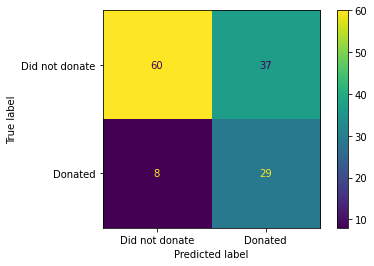

In [28]:
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_test, y_test, display_labels=["Did not donate", "Donated"])

Optimized **XGBoost** model is a lot better at identifying donated people. Of the **37** people that donated, **29(78.38%)** were correctly identified. Before optimization, we only correctly identified **8(21.62%)**.
However, this improvement was at the expense of not being able to correctly classify as many as people that did not donate.
Before optimization. we correctly identidied **83(85.56%)** people that did not donate. Now we only correctly classify **60(61.86%)**. That said, this trade off may be better for hospitals and blood banks so that in emergency cases they could call the donated people immediatly.

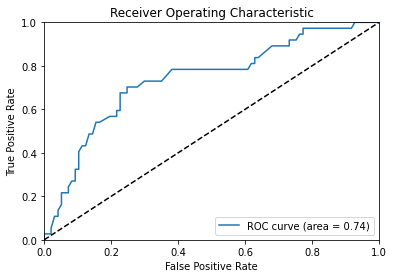

In [29]:
# Predict probabilities for test data
y_scores = clf_xgb.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Drawing first tree

weight:  {'f0': 2.0, 'f1': 1.0}
gain:  {'f0': 14.09770393371582, 'f1': 0.940150260925293}
cover:  {'f0': 109.375, 'f1': 63.75}
total_gain:  {'f0': 28.19540786743164, 'f1': 0.940150260925293}
total_cover:  {'f0': 218.75, 'f1': 63.75}


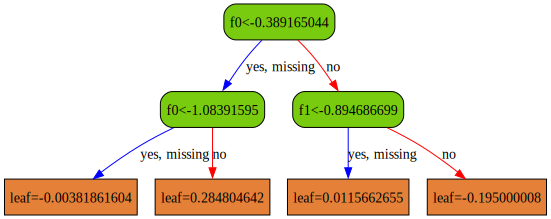

In [30]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            gamma=0.25,
                            learning_rate = 0.8,
                            max_depth = 2,
                            reg_lambda = 100,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            colsample_bytree=0.5,
                            n_estimators=1,
                            random_state=42)

clf_xgb.fit(X_train, y_train)

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
                'style': 'filled, rounded',
                'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
                'style': 'filled',
                'fillcolor': '#e48038'}
    
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)
    
#to save the figure
# gragh_data = xgb.to_graghviz(clf_xgb, num_trees=0, size="10,10",
#                condition_node_params=node_params,
#                leaf_node_params=leaf_params)
#save as pdf
# gragh_data.view(filename='xgboost_tree')

## prediction

In [31]:
a=std_scaler.transform(np.array([[2,50,12500,98]]))

In [32]:
b=std_scaler.transform(np.array([[1, 24, 6000, 77]]))

In [33]:
clf_xgb.predict(a)

array([1])

In [34]:
clf_xgb.predict(b)

array([0])

In [35]:
a.shape

(1, 4)

## Export the model

In [36]:
filename = 'final_model.sav'
joblib.dump((clf_xgb, std_scaler), filename)

['final_model.sav']